# Project 4: Cd-Aufnahme über die Nahrung bei Folsomia

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pal = sns.color_palette()
from scipy import stats
import pandas as pd
from copy import deepcopy
import pprint
pp = pprint.PrettyPrinter(indent=2)
import os
import pyarrow

current_dir = os.path.dirname(os.path.abspath(''))
project_directory = os.path.dirname(current_dir)

# automatische aktualisierung externer Python-Dateien
%load_ext autoreload
%autoreload 2 

# Einbindung zusätzlicher Funktionen 
from utils import * 
from ModelFitting import *
from mempyDEB.DEBODE.simulators import *
from mempyDEB.DEBODE.defaultparams import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Start by fitting the model to control data

In [26]:
from DEBfitting_Folsomia import *
data = load_data()
data.head()

,t_day,length_mm,C_F,T_cels,S
85,0,0.609,0,20,1.420620
86,2,0.723,0,20,1.999511
87,4,0.857,0,20,2.805551
88,7,1.019,0,20,3.960986
89,9,1.095,0,20,4.571232


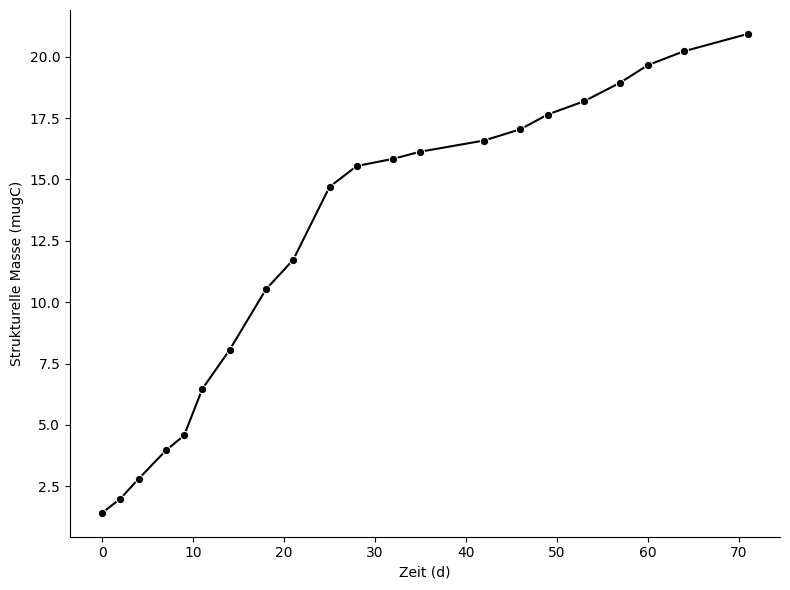

In [27]:
_ = plot_data(data)

c:\Users\hdeve\Documents\Master_Umsys_Rema_Osnabrück\Semester_1\Mechanistische_Effekt_Modellierung\Übung\mem25\Projekt\mempyDEB\DEBfitting_Folsomia.py:89: RuntimeWarning: invalid value encountered in scalar power
  p.spc['Idot_max_rel_emb'] *= zoom_factor_theta**(1/3)


Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'Idot_max_rel': np.float64(4.5483797877675745), 'eta_AS_0': np.float64(0.40638832287776183)}


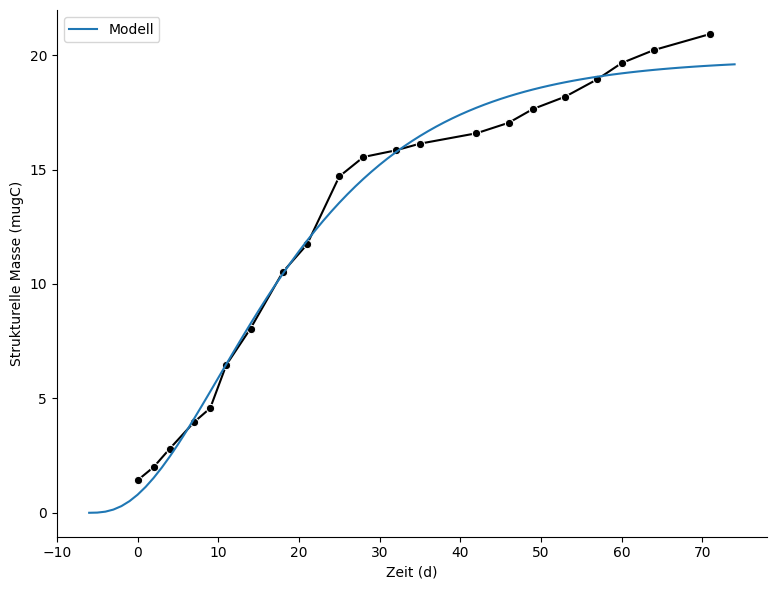

In [28]:
f = fit_model()

c:\Users\hdeve\Documents\Master_Umsys_Rema_Osnabrück\Semester_1\Mechanistische_Effekt_Modellierung\Übung\mem25\Projekt\mempyDEB\DEBfitting_Folsomia.py:89: RuntimeWarning: invalid value encountered in scalar power
  p.spc['Idot_max_rel_emb'] *= zoom_factor_theta**(1/3)


Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'Idot_max_rel': np.float64(4.5483797877675745), 'eta_AS_0': np.float64(0.40638832287776183)}


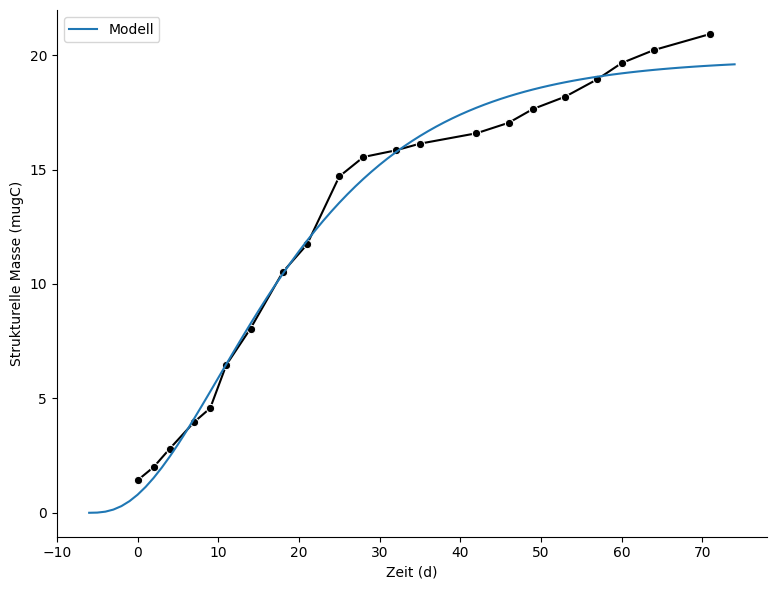

In [30]:
def fit_model_2params():
    """
    DEB-Modellkalibrierung mit zwei Parametern.
    """

    # Definition des ModelFit - Objektes wie zuvor
    f = setup_modelfit() 
    
    # wir müssen hier lediglich den initial guess anpassen
    f.intguess = { 
        'Idot_max_rel' : f.defaultparams.spc['Idot_max_rel'], 
        'eta_AS_0' : f.defaultparams.spc['eta_AS_0']
    }

    # am restlichen Code ändert sich ersmtal nichts

    f.run_optimization()

    print(f"Estimated parameter values: {f.p_opt}")

    # simulate optimized parameters, 

    p = deepcopy(f.defaultparams)
    p.spc.update(f.p_opt)  

    sim_opt = f.simulator(p.spc)

    # plot data + retrodiction

    fig, ax = plot_data(f.data)

    sns.lineplot(sim_opt, x = 't_day', y = 'S', ax = ax, label = "Modell")
    #sns.lineplot(sim_opt, x = 't_day', y = 'cum_repro', ax = ax[1])

    #ax[1].legend()

    return f
 
f_2params = fit_model_2params()

control_fitted_params = f_2params.p_opt


In [31]:
control_fitted_params

{'Idot_max_rel': np.float64(4.5483797877675745),
 'eta_AS_0': np.float64(0.40638832287776183)}

### Bayesian Inference

In [ ]:
# f.define_lognorm_prior()
# f.run_bayesian_inference(
#     popsize = 35,
#     max_total_nr_simulations = 1_000)

ABC.History INFO: Start <ABCSMC id=8, start_time=2025-03-04 16:03:30>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 7.00459551e+00.
ABC INFO: Accepted: 35 / 58 = 6.0345e-01, ESS: 3.5000e+01.
ABC INFO: t: 1, eps: 2.24587404e-01.
ABC INFO: Accepted: 35 / 99 = 3.5354e-01, ESS: 3.1957e+01.
ABC INFO: t: 2, eps: 8.17113957e-02.
ABC INFO: Accepted: 35 / 66 = 5.3030e-01, ESS: 2.8972e+01.
ABC INFO: t: 3, eps: 3.66123519e-02.
ABC INFO: Accepted: 35 / 109 = 3.2110e-01, ESS: 3.0618e+01.
ABC INFO: t: 4, eps: 1.33814271e-02.
ABC INFO: Accepted: 35 / 91 = 3.8462e-01, ESS: 3.3380e+01.
ABC INFO: t: 5, eps: 8.04417783e-03.
ABC INFO: Accepted: 35 / 73 = 4.7945e-01, ESS: 3.4000e+01.
ABC INFO: t: 6, eps: 4.64160374e-03.
ABC INFO: Accepted: 35 / 91 = 3.8462e-01, ESS: 3.2184e+01.
ABC INFO: t: 7, eps: 2.51467988e-03.
ABC INFO: Accepted: 35 / 77 = 4.5455e-01, ESS: 3.3569e+01.
ABC INFO: t: 8, eps: 1.64932524e-03.
ABC INFO: Accepted: 35 / 74 = 4.7297e-01, ESS: 3.1060e+01.
ABC INFO: t: 9, eps: 1.11513

Conducted Bayesian inference using SMC-ABC. Results are in `abc_history` and `accepted`


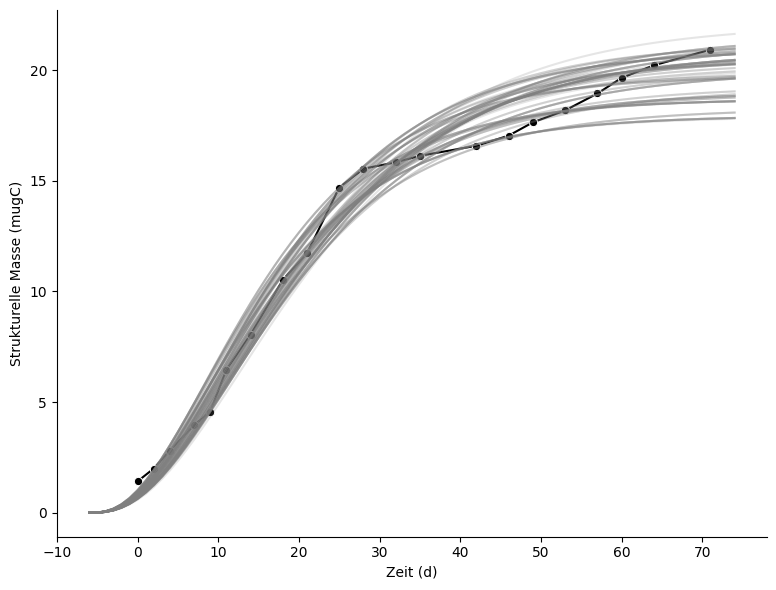

In [ ]:
# f.retrodict()
# fig,ax = plot_data(f.data)

# for df in f.retrodictions:
    
#     sns.lineplot(df, x = 't_day', y = 'S', ax = ax, alpha = .2, color = 'gray')

## use control fit to fit TKTD model

In [51]:
from TKTDFitting_Folsomia import *

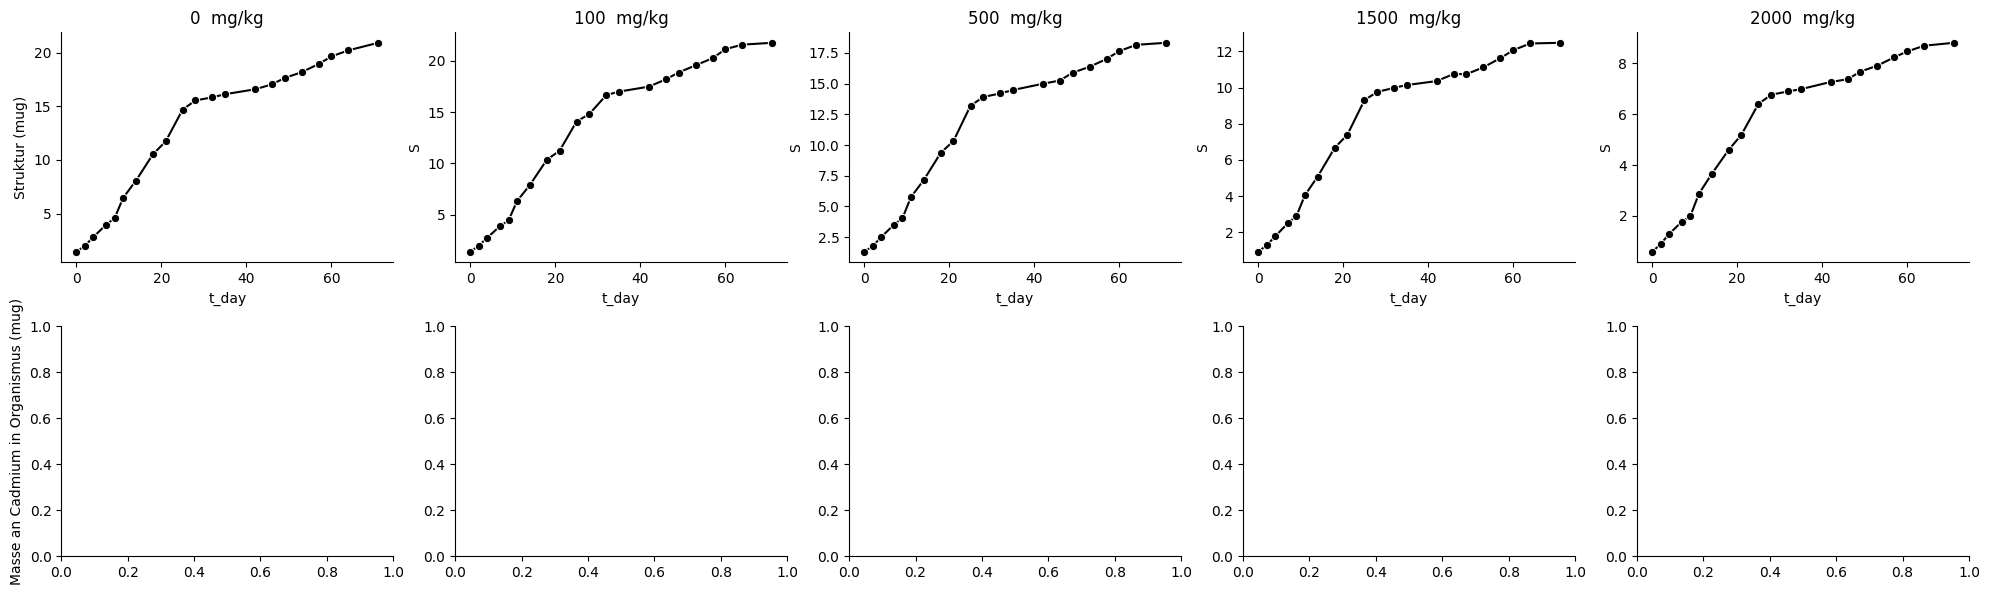

In [ ]:
data = load_data()
fig, ax = plot_data(data)


array([[<Axes: title={'center': '0  mg/kg'}, xlabel='t_day', ylabel='Struktur (mug)'>,
        <Axes: title={'center': '100  mg/kg'}, xlabel='t_day', ylabel='S'>,
        <Axes: title={'center': '500  mg/kg'}, xlabel='t_day', ylabel='S'>,
        <Axes: title={'center': '1500  mg/kg'}, xlabel='t_day', ylabel='S'>,
        <Axes: title={'center': '2000  mg/kg'}, xlabel='t_day', ylabel='S'>],
       [<Axes: xlabel='t_day', ylabel='Masse an Cadmium in Organismus (mug)'>,
        <Axes: xlabel='t_day', ylabel='Cd_in'>,
        <Axes: xlabel='t_day', ylabel='Cd_in'>,
        <Axes: xlabel='t_day', ylabel='Cd_in'>,
        <Axes: xlabel='t_day', ylabel='Cd_in'>]], dtype=object)

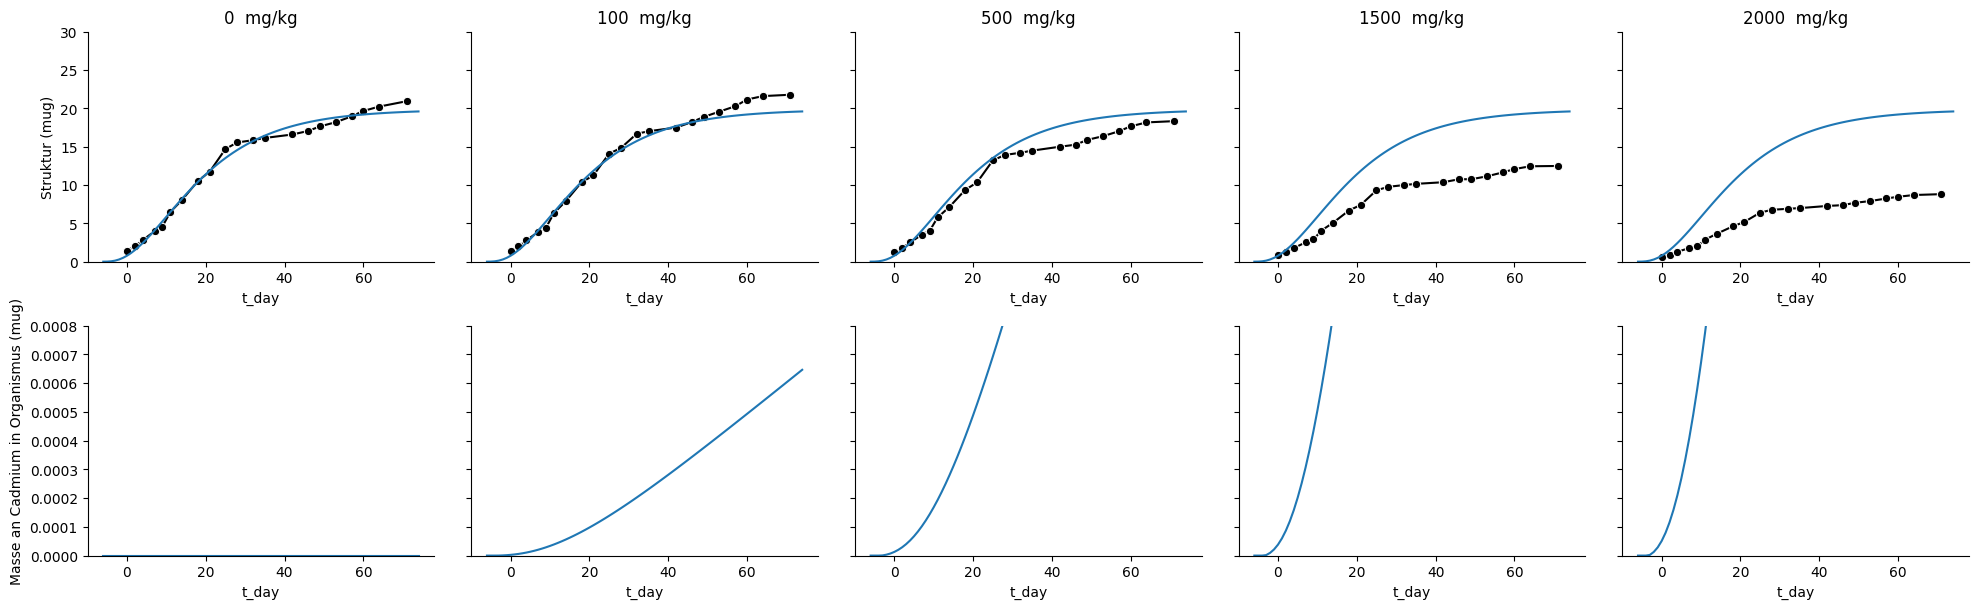

In [54]:
f = setup_modelfit()
f.defaultparams.spc.update(control_fitted_params)

sim_intguess = f.simulator(control_fitted_params)
sim_intguess
data = load_data()
fig, ax = plot_data(data)

plot_sim(ax, sim_intguess)


## trying out different PMoA

## fitting different levels of Cd-exposition from food ingestion/assimilation